# Optimizing TENO5 with Sod's Shock Tube

### Import necessary modules

In [1]:
from boiles.test_cases.sod_60 import SodDisper60
from boiles.config import OC, OP
OP.test_cases = [SodDisper60]
# above imports is a legacy problem, will be changed in future version

import warnings
from gpytorch.utils.warnings import NumericalWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=NumericalWarning)

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from ax.core import SimpleExperiment
from ax.modelbridge import get_sobol
from ax import ParameterType, SearchSpace
import numpy as np
from ax.modelbridge.factory import get_botorch
import random
import torch

# delete previously generated files
import os
os.system("rm -rf runtime_data/case.* runtime_data/opt_history.csv runtime_data/model_state runtime_data/sod_runtime_samples.csv log.txt discrete")

# define some global variables
# 365481
random_seed = 112
initial_samples = 10
opt_iterations = 40
bounds = ((1, 10), (1, 100), (0.2, 0.9))
# the steps for each parameter
intervals = (1, 1, 0.001)

### Define a GP surrogate model

In [2]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        noise = torch.ones(train_X.shape[0]) * 0.001
        super().__init__(train_X, train_Y.squeeze(-1), FixedNoiseGaussianLikelihood(noise))
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

### Define a function to build GP and fit GP, return the fitted GP

In [3]:
def get_and_fit_simple_custom_gp(Xs, Ys, **kwargs):
    model = SimpleCustomGP(Xs[0], Ys[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

### Define the optimization problem

Here we use 1D ALPACA to run Sod's shock tube and compute the total error of density, velocity and pressure.

In [4]:
import xml.etree.ElementTree as ET
from boiles.objective.sodshocktube import Sod
from boiles.utils import append_to_csv, log
import time

schemefile = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/runtime_data/scheme.xml"
inputfile = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/inputfiles/sod_60.xml"
alpaca = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/ALPACA_60_TENO5RL"

# we use an xml file to inform the ALPACA the parameters of TENO5. We can get rid of compiling in this way
def configure_scheme_xml(para):
    tree = ET.ElementTree(file=schemefile)
    root = tree.getroot()
    root[0].text = "0"
    q, cq, eta = para[0], para[1], para[2]
    ct = 1e-5
    for i, para in enumerate([q, cq, eta, ct]):
        root[i].text = str(para)
    tree.write(schemefile)

def sod_disper_sum_error(para, case_num):
    q, cq, eta = para
    configure_scheme_xml(para)
    os.system(f"cd runtime_data; mpiexec -n 1 {alpaca} {inputfile}")
    os.system(f"mv runtime_data/sod_60 runtime_data/case.{case_num}")
    
    sod = Sod(file=f"runtime_data/case.{case_num}/domain/data_0.200*.h5")
    sod_disper, sod_disper_raw, state_disper = sod.objective_sum_disper()
    log(f'Sod case.{case_num:<2} with q={int(q):<3} cq={int(cq):<4} eta={format(eta, ".3f"):<4}; Dispersion error: {format(sod_disper, ".4f")}')

    append_to_csv(f'runtime_data/sod_runtime_samples.csv',
                  [case_num, q, cq, eta, sod_disper, sod_disper_raw, state_disper])
    return sod_disper

class SodMetrics:  
    
    def __init__(self):
        super().__init__()
        self.case_num = 1  # count the number of test case
        self.data_dict = {}  # use a dict to retrieve data
        
    def sod_error(self, x):
        q, cq, eta = x["q"], x["cq"], x["eta"]
        if self.data_dict.get(f"{str(q)}, {str(cq)}, {format(eta, '.2f')}", None) is None:
            sod_disper = sod_disper_sum_error([q, cq, eta], self.case_num)
            self.data_dict[f"{str(q)}, {str(cq)}, {format(eta, '.2f')}"] = sod_disper
            self.case_num += 1
        else:
            sod_disper = self.data_dict[f"{str(q)}, {str(cq)}, {format(eta, '.2f')}"]

        return sod_disper

sod_metrics = SodMetrics()
name = "disper"

def sod_disper(x):
    return {name: (sod_metrics.sod_error(x), 0)}

### Build an experiment and return

In [5]:
def build_exp(search_space, seed=random_seed, minimize=True):
    exp = SimpleExperiment(
        name=name,
        search_space=search_space,
        evaluation_function=sod_disper,
        objective_name=name,
        minimize=minimize,
    )
    sobol = get_sobol(exp.search_space, seed=seed)
    exp.new_batch_trial(generator_run=sobol.gen(initial_samples))
    return exp

### Define the optimization loop

This loop is different from the Botorch tutorial. In that tutorial, the optimization stops after generating a sample, i.e. training -> generating -> training -> ... -> training -> generating.

With this loop, the optimization stops after training a final model. The number of all samples is the same with what we defined.

At each iteration the GP model is saved

In [6]:
from boiles.utils import save_single_model_state

def optimize(search_space, seed, minimize=True):
    exp = build_exp(search_space, seed, minimize)
    # buiding the initial GP
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=get_and_fit_simple_custom_gp,
    )
    save_single_model_state(model, 0, name)
    # start optimization loop
    for i in range(opt_iterations):
        print(f"Running optimization batch {i + 1}/{opt_iterations}...")
        generator_run = model.gen(1)
        exp.new_trial(generator_run=generator_run)
        model = get_botorch(
            experiment=exp,
            data=exp.eval(),
            search_space=exp.search_space,
            model_constructor=get_and_fit_simple_custom_gp,
        )
        save_single_model_state(model, i + 1, name)
    print("Done!")
    return model, exp

### Optimizing the Sod's shock tube

In [7]:
from ax import ChoiceParameter

parameter_space = SearchSpace(
    parameters=[
        ChoiceParameter(
            name="q",
            parameter_type=ParameterType.INT,
            values=torch.arange(bounds[0][0], bounds[0][1]+1e-6, intervals[0]),
            is_ordered=True,
            sort_values=True
        ),
        ChoiceParameter(
            name="cq",
            parameter_type=ParameterType.INT,
            values=torch.arange(bounds[1][0], bounds[1][1]+1e-6, intervals[1]),
            is_ordered=True,
            sort_values=True
        ),
        ChoiceParameter(
            name="eta",
            parameter_type=ParameterType.FLOAT,
            values=torch.arange(bounds[2][0], bounds[2][1]+1e-6, intervals[2]),
            is_ordered=True,
            sort_values=True
        ),
    ]
)
model, exp = optimize(
    search_space=parameter_space,
    seed=random_seed
)

Sod case.1  with q=5   cq=89   eta=0.821; Dispersion error: 0.3405
Sod case.2  with q=9   cq=17   eta=0.444; Dispersion error: 0.0351
Sod case.3  with q=7   cq=60   eta=0.593; Dispersion error: 0.2035
Sod case.4  with q=1   cq=37   eta=0.342; Dispersion error: 0.6000
Sod case.5  with q=3   cq=73   eta=0.521; Dispersion error: 0.2592
Sod case.6  with q=6   cq=45   eta=0.766; Dispersion error: 0.3066
Sod case.7  with q=10  cq=81   eta=0.266; Dispersion error: 0.2586
Sod case.8  with q=3   cq=3    eta=0.648; Dispersion error: 0.2151
Sod case.9  with q=4   cq=57   eta=0.206; Dispersion error: 0.4120
Sod case.10 with q=10  cq=27   eta=0.706; Dispersion error: 0.1329
Running optimization batch 1/40...
Sod case.11 with q=9   cq=7    eta=0.790; Dispersion error: 0.1136
Running optimization batch 2/40...
Sod case.12 with q=10  cq=12   eta=0.200; Dispersion error: 0.0211
Running optimization batch 3/40...
Sod case.13 with q=8   cq=10   eta=0.200; Dispersion error: 0.0378
Running optimization bat

### Find the optimum

- if the *trial_index* is zero, this case is in initial samples. The seconde number of *arm_name* plusing 1 is the case number;
- if the *trial_index* is nonzero, this case is in optimization iteration. It's better to find the case number through looking the log.

In [8]:
from ax.service.utils.report_utils import exp_to_df
sorted_df = exp_to_df(exp).sort_values(by=[name]).head()
opt_x = [sorted_df.head(1).q.values[0], sorted_df.head(1).cq.values[0], sorted_df.head(1).eta.values[0]]
print("opt_x: ", opt_x)
sorted_df

opt_x:  [10.0, 11.0, 0.3310000002384186]


disper  trial_index arm_name    cq    eta     q trial_status  \
43  0.008174           40     35_0  11.0  0.331  10.0    COMPLETED   
41  0.008174           38     33_0  11.0  0.327  10.0    COMPLETED   
40  0.008174           37     31_0  11.0  0.329  10.0    COMPLETED   
39  0.008174           36     32_0  11.0  0.330  10.0    COMPLETED   
38  0.008174           35     35_0  11.0  0.331  10.0    COMPLETED   

   generation_method  
43                BO  
41                BO  
40                BO  
39                BO  
38                BO

### Plot a 3D volume using Plotly

Since we have three input parameters, the input space is 3D. We use plotly to draw such a space and interact with it.

In [9]:
from ax.models.torch.utils import predict_from_model
import plotly.graph_objects as go
import gpytorch

# get all samples
data = []
for obs in model.get_training_data():
    x = obs.features.parameters
    data.append([x["q"], x["cq"], x["eta"], obs.data.means[0]])
data = np.array(data)

n = 30
x = torch.linspace(0, 1, n).reshape(-1, 1)
x_test = gpytorch.utils.grid.create_data_from_grid(x.repeat(1, 3))
pred, var = predict_from_model(model.model.model, x_test)
pred = pred.numpy().reshape((n, n, n))

# don't doubt the order, it is correct
y, z, x = np.meshgrid(
    torch.linspace(bounds[1][0], bounds[1][1], n).reshape(-1, 1),
    torch.linspace(bounds[2][0], bounds[2][1], n).reshape(-1, 1),
    torch.linspace(bounds[0][0], bounds[0][1], n).reshape(-1, 1)
)

fig_list = []
volume = go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=pred.flatten(),
    isomin=pred.min(),
    isomax=abs(pred.min()) * 0.1 + pred.min(),
    opacity=0.3,  # needs to be small to see through all surfaces
    surface_count=20,  # needs to be a large number for good volume rendering
    colorscale="Viridis"
)
fig_list += [volume]
scatter = go.Scatter3d(
    x=data[:, 0].flatten(),
    y=data[:, 1].flatten(),
    z=data[:, 2].flatten(),
    mode="markers",
    marker=dict(color="red", symbol="x", size=1.5)
)
fig = go.Figure()
fig.add_trace(volume)
fig.add_trace(scatter)

fig.update_layout(
    autosize=True,
    scene=dict(
        xaxis=dict(range=[bounds[0][0], bounds[0][1]]),
        yaxis=dict(range=[bounds[1][0], bounds[1][1]]),
        zaxis=dict(range=[bounds[2][0], bounds[2][1]])
    ),
    width=600,
    height=600,
    title="GP",
    showlegend=False,
)
fig.show()

### Plot the Sod's shock tube with optimal and Lin's parameters

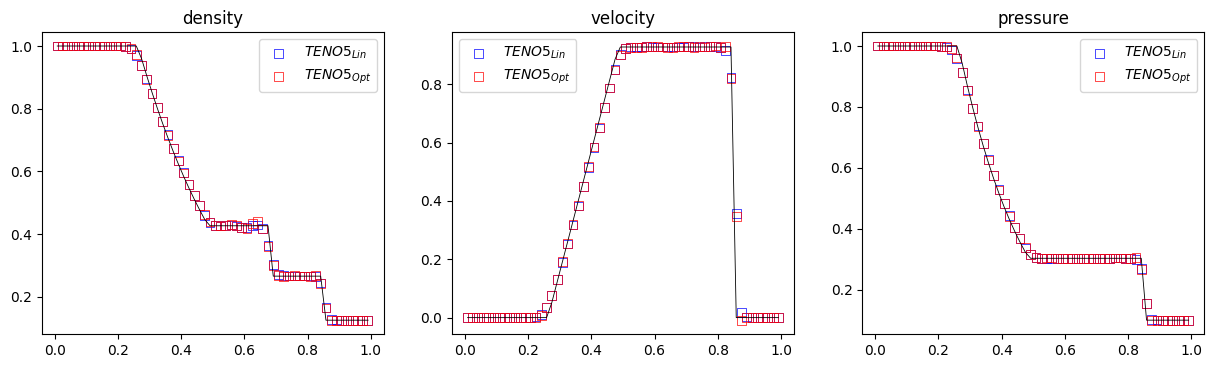

In [10]:
import matplotlib.pyplot as plt

os.system("rm -rf runtime_data/sod*")


inputfile = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/inputfiles/sod_60.xml"
alpaca = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/ALPACA_60_TENO5RL"

configure_scheme_xml([6, 1, 0.200])
os.system(f"cd runtime_data; mpiexec -n 1 {alpaca} {inputfile}")
os.system(f"mv runtime_data/sod_60 runtime_data/sod_lin")

configure_scheme_xml(opt_x)
os.system(f"cd runtime_data; mpiexec -n 1 {alpaca} {inputfile}")
os.system(f"mv runtime_data/sod_60 runtime_data/sod_opt")

sod_opt = Sod(file="runtime_data/sod_opt/domain/data_0.200000.h5")
sod_lin = Sod(file="runtime_data/sod_lin/domain/data_0.200000.h5")
states = ("density", "velocity", "pressure")
x = sod_lin.result["x_cell_center"]
plt.figure(figsize=(15, 4), dpi=100)
for i, state in enumerate(states):
    plt.subplot(1, 3, i+1)
    plt.title(state)
    plt.plot(x, sod_lin.reference[state], c="black", linewidth=0.6)
    plt.scatter(x, sod_lin.result[state], label=r"$TENO5_{Lin}$", marker="s", facecolor='none', edgecolor="blue", linewidth=0.5, s=40)
    plt.scatter(x, sod_opt.result[state], label=r"$TENO5_{Opt}$", marker="s", facecolor='none', edgecolor="red", linewidth=0.5, s=40)
    plt.legend()

### Check the improvement

In [11]:
import pandas as pd

density = [sod_lin.get_all_value_difference("density"), sod_opt.get_all_value_difference("density")]
velocity = [sod_lin.get_all_value_difference("velocity"), sod_opt.get_all_value_difference("velocity")]
pressure = [sod_lin.get_all_value_difference("pressure"), sod_opt.get_all_value_difference("pressure")]
pd.DataFrame({"density": density, "velocity": velocity, "pressure": pressure}, index=["Lin", "Opt"])

density  velocity  pressure
Lin  0.055041  0.093382  0.067757
Opt  0.056087  0.089547  0.064976

### Test Shu-Osher problem with optimum

the printed values are the dispersion errors

(26.91312858092026, 26.91312858092026, 'completed') (25.430596293375462, 25.430596293375462, 'completed')


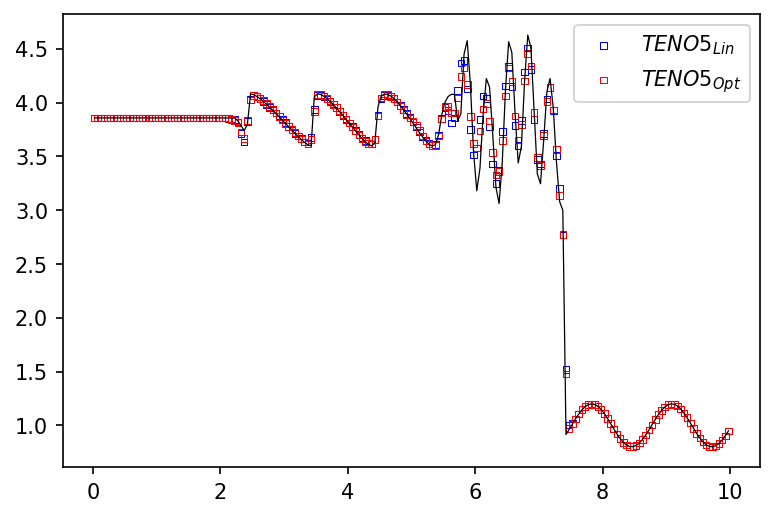

In [12]:
from boiles.objective.shuosher import ShuOsher

os.system("rm -rf runtime_data/shu*")

inputfile = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/inputfiles/shu_200.xml"
alpaca = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/ALPACA_40_TENO5RL"

configure_scheme_xml(opt_x)
os.system(f"cd runtime_data; mpiexec -n 4 {alpaca} {inputfile}")
os.system(f"mv runtime_data/shu_200 runtime_data/shu_opt")

configure_scheme_xml([6, 1, 0.200])
os.system(f"cd runtime_data; mpiexec -n 4 {alpaca} {inputfile}")
os.system(f"mv runtime_data/shu_200 runtime_data/shu_lin")

shu_lin = ShuOsher(file="runtime_data/shu_lin/domain/data_1.800000.h5")
shu_opt = ShuOsher(file="runtime_data/shu_opt/domain/data_1.800000.h5")

plt.figure(dpi=150)
plt.plot(shu_lin.result["x_cell_center"], shu_lin.reference["density"], c="black", linewidth=0.6)
plt.scatter(shu_lin.result["x_cell_center"], shu_lin.result["density"], label=r"$TENO5_{Lin}$", marker="s", facecolor='none', edgecolor="blue", linewidth=0.5, s=10)
plt.scatter(shu_opt.result["x_cell_center"], shu_opt.result["density"], label=r"$TENO5_{Opt}$", marker="s", facecolor='none', edgecolor="red", linewidth=0.5, s=10)
plt.legend()
print(shu_lin.objective_disper(), shu_opt.objective_disper())

### Test implosion problem with optimum

less oscillations and more structures

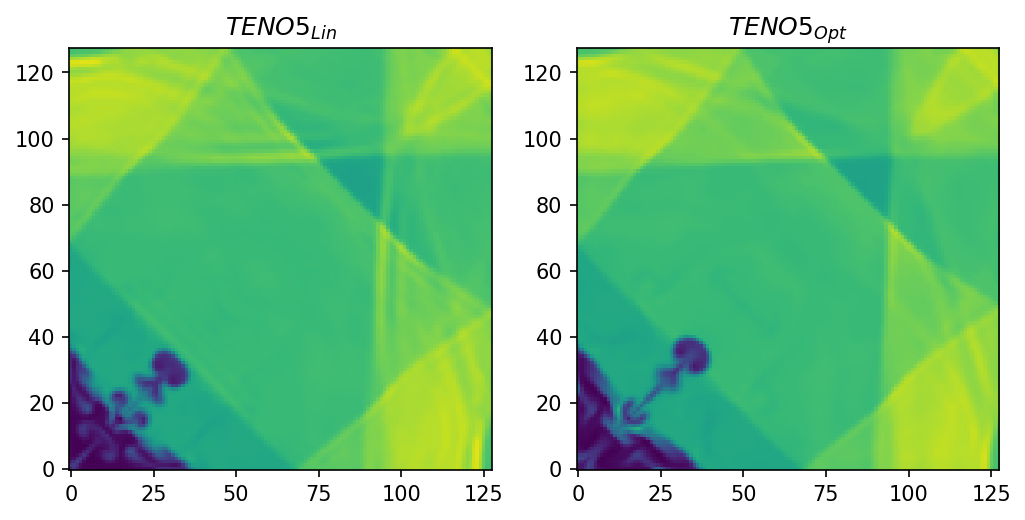

In [13]:
from boiles.objective.simulation2d import Simulation2D

os.system("rm -rf runtime_data/implosion*")
inputfile = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/inputfiles/implosion.xml"
alpaca = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/ALPACA_2D32_TENO5RL"

configure_scheme_xml(opt_x)
os.system(f"cd runtime_data; mpiexec -n 6 {alpaca} {inputfile}")
os.system(f"mv runtime_data/implosion runtime_data/implosion_opt")

configure_scheme_xml([6, 1, 0.200])
os.system(f"cd runtime_data; mpiexec -n 6 {alpaca} {inputfile}")
os.system(f"mv runtime_data/implosion runtime_data/implosion_lin")

imp_lin = Simulation2D(file="runtime_data/implosion_lin/domain/data_2.500000.h5")
imp_opt = Simulation2D(file="runtime_data/implosion_opt/domain/data_2.500000.h5")
plt.figure(figsize=(8, 4), dpi=150)
for i, imp in enumerate(zip([imp_lin, imp_opt], [r"$TENO5_{Lin}$", r"$TENO5_{Opt}$"])):
    plt.subplot(1, 2, i+1)
    plt.imshow(imp[0].result["density"], origin="lower", vmin=0.4, vmax=1.1)
    plt.title(imp[1])

### Test a Riemann problem with optimum

more structures

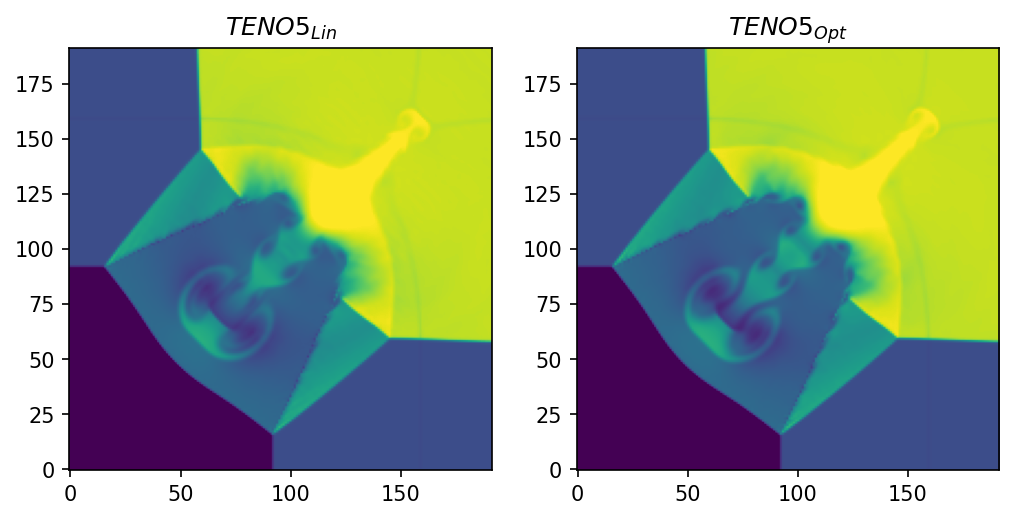

In [14]:
os.system("rm -rf runtime_data/riemann2d*")

inputfile = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/inputfiles/riemann2d.xml"
alpaca = "/media/yiqi/Fengyiqi/TUM/TENO5/teno5_eta_sod_conference/ALPACA_2D32_TENO5RL"

configure_scheme_xml(opt_x)
os.system(f"cd runtime_data; mpiexec -n 6 {alpaca} {inputfile}")
os.system(f"mv runtime_data/riemann2d runtime_data/riemann2d_opt")

configure_scheme_xml([6, 1, 0.200])
os.system(f"cd runtime_data; mpiexec -n 6 {alpaca} {inputfile}")
os.system(f"mv runtime_data/riemann2d runtime_data/riemann2d_lin")

rie_lin = Simulation2D(file="runtime_data/riemann2d_lin/domain/data_1.000000.h5")
rie_opt = Simulation2D(file="runtime_data/riemann2d_opt/domain/data_1.000000.h5")
plt.figure(figsize=(8, 4), dpi=150)
for i, imp in enumerate(zip([rie_lin, rie_opt], [r"$TENO5_{Lin}$", r"$TENO5_{Opt}$"])):
    plt.subplot(1, 2, i+1)
    plt.imshow(imp[0].result["density"], origin="lower", vmin=0.2, vmax=1.6)
    plt.title(imp[1])